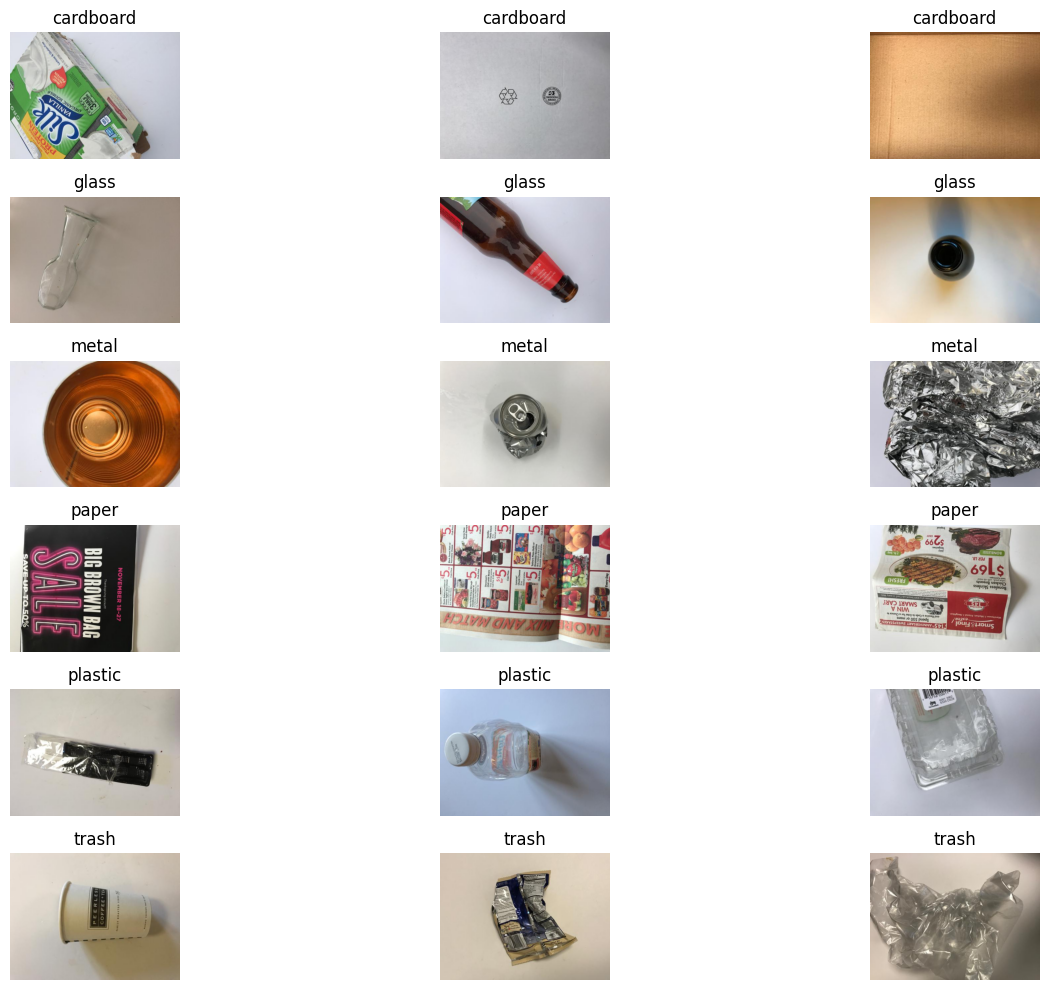

In [5]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the path to the dataset
dataset_path = "../TrashType_Image_Dataset"

# Define the categories
categories = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Define the number of images to display from each category
num_images_to_display = 3

# Set up the plot
fig, axes = plt.subplots(len(categories), num_images_to_display, figsize=(15, 10))

# Loop through each category
for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    image_files = os.listdir(category_path)
    random.shuffle(image_files)  # Shuffle the list of image files

    # Display randomly selected images
    for j in range(num_images_to_display):
        img_file = image_files[j]
        img_path = os.path.join(category_path, img_file)
        img = mpimg.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(category)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


In [6]:
from sklearn.model_selection import train_test_split
import shutil

# Define the path to the dataset
dataset_path = "../TrashType_Image_Dataset"

# Define the categories
categories = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Define the ratio of images to be allocated for the test set
test_size = 0.2

# Create directories for the training and test sets
train_dir = "../train_dataset"
test_dir = "../test_dataset"

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Loop through each category
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = os.listdir(category_path)

    # Split the image files into training and test sets
    train_images, test_images = train_test_split(image_files, test_size=test_size, random_state=42)

    # Copy training images to the train dataset directory
    for img_file in train_images:
        src_path = os.path.join(category_path, img_file)
        dest_path = os.path.join(train_dir, img_file)
        shutil.copy(src_path, dest_path)

    # Copy test images to the test dataset directory
    for img_file in test_images:
        src_path = os.path.join(category_path, img_file)
        dest_path = os.path.join(test_dir, img_file)
        shutil.copy(src_path, dest_path)

print("Dataset split into training and test sets successfully.")

Dataset split into training and test sets successfully.


In [7]:
def sort_images_into_folders(dataset_dir):
    # Iterate through the images in the dataset directory
    for filename in os.listdir(dataset_dir):
        if os.path.isfile(os.path.join(dataset_dir, filename)):
            # Extract the class name from the filename (e.g., cardboard, metal, etc.)
            class_name = filename.split("_")[0]

            # Create the class folder if it doesn't exist
            class_folder = os.path.join(dataset_dir, class_name)
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)

            # Move the image to the class folder
            src = os.path.join(dataset_dir, filename)
            dst = os.path.join(class_folder, filename)
            shutil.move(src, dst)

# Define the paths to the train and test dataset directories
train_dataset_dir = "../train_dataset"
test_dataset_dir = "../test_dataset"

# Sort images into class folders for the train dataset
print("Sorting train dataset images into class folders...")
sort_images_into_folders(train_dataset_dir)
print("Train dataset images sorted successfully.")

# Sort images into class folders for the test dataset
print("Sorting test dataset images into class folders...")
sort_images_into_folders(test_dataset_dir)
print("Test dataset images sorted successfully.")

Sorting train dataset images into class folders...
Train dataset images sorted successfully.
Sorting test dataset images into class folders...
Test dataset images sorted successfully.


In [9]:
def count_images_in_split(folder):
    print(f"Folder: {folder}")
    classes = []
    for root, dirs, files in os.walk(folder):
        for d in dirs:
            classes.append(d)
    print(f"Classes: {classes}")
    for class_name in classes:
        class_path = os.path.join(folder, class_name)
        num_images = len(os.listdir(class_path))
        print(f"Class: {class_name} - Number of Images: {num_images}")

# Verify the number of images in each split for each class
print("Training Set:")
count_images_in_split('train_dataset/')

print("\nTest Set:")
count_images_in_split('test_dataset/')

Training Set:
Folder: train_dataset/
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Class: cardboard - Number of Images: 322
Class: glass - Number of Images: 400
Class: metal - Number of Images: 328
Class: paper - Number of Images: 475
Class: plastic - Number of Images: 385
Class: trash - Number of Images: 109

Test Set:
Folder: test_dataset/
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Class: cardboard - Number of Images: 81
Class: glass - Number of Images: 101
Class: metal - Number of Images: 82
Class: paper - Number of Images: 119
Class: plastic - Number of Images: 97
Class: trash - Number of Images: 28


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.debugging.set_log_device_placement(True)

# Sometimes TF allocates all GPU memory
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Define paths to the training and test datasets
train_dir = "../train_dataset/"
test_dir = "../test_dataset/"

# Define image dimensions
img_height = 512
img_width = 384
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/Test Data Generator (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2019 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


In [11]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the InceptionV3 model pretrained on ImageNet without the top layer
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add new top layers for classification
x = base_model_inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions_inception = Dense(6, activation='softmax')(x)  # 6 output classes for your dataset

# Define the new model
model_inception = Model(inputs=base_model_inception.input, outputs=predictions_inception)

# Freeze the layers of the pretrained model
for layer in base_model_inception.layers:
    layer.trainable = False

# Compile the model
model_inception.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_inception = model_inception.fit(train_generator, epochs=50, validation_data=validation_generator)

input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:CPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
x: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
Cast: (Cast): /job:localhost/replica:0/task:0/device:CPU:0
y_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:CPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
x: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
y: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
FloorMod: (FloorMod): /job:localhost/replica:0/task:0/device

2025-06-14 14:48:17.852498: I tensorflow/core/common_runtime/placer.cc:162] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:17.852511: I tensorflow/core/common_runtime/placer.cc:162] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:17.852513: I tensorflow/core/common_runtime/placer.cc:162] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:17.858887: I tensorflow/core/common_runtime/placer.cc:162] x: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:17.858898: I tensorflow/core/common_runtime/placer.cc:162] Cast: (Cast): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:17.858900: I tensorflow/core/common_runtime/placer.cc:162] y_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:17.861133: I tensorflow/core/common_runtime/placer.cc:162] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:

Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:

2025-06-14 14:48:18.063734: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.063753: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.067662: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.067677: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.070197: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.070212: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.072984: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
resource_RetVal: (_Retval): /job:localhost/replic

2025-06-14 14:48:18.360011: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.360023: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.360788: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.360795: I tensorflow/core/common_runtime/placer.cc:162] value: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.360798: I tensorflow/core/common_runtime/placer.cc:162] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.362878: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.362885: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/

VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0

2025-06-14 14:48:18.562229: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.562235: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.564224: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.564230: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.569035: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.569043: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.569700: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localho

resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0

2025-06-14 14:48:18.762566: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.765077: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.765085: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.766675: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.766682: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.768134: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.768141: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /j

resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/re

2025-06-14 14:48:18.963316: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.963324: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.970664: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.970676: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.971962: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.971975: I tensorflow/core/common_runtime/placer.cc:162] value: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:18.971982: I tensorflow/core/common_runtime/placer.cc:162] AssignVariableOp: (AssignVariableOp): /job:localhost/

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

2025-06-14 14:48:19.302482: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:19.302493: I tensorflow/core/common_runtime/placer.cc:162] value: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:19.302497: I tensorflow/core/common_runtime/placer.cc:162] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:19.304581: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:19.304589: I tensorflow/core/common_runtime/placer.cc:162] value: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:19.304592: I tensorflow/core/common_runtime/placer.cc:162] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:19.308347: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandle

2025-06-14 14:48:21.941214: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:21.941225: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:21.949289: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:21.949300: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:21.956384: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:21.956392: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:21.963443: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

resource: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
is__initialized_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
is__initialized_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
is__initialized_RetVal: (_Retval): /job:lo

2025-06-14 14:48:22.165065: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:22.165079: I tensorflow/core/common_runtime/placer.cc:162] VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:22.165081: I tensorflow/core/common_runtime/placer.cc:162] is__initialized_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:22.168422: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:22.168431: I tensorflow/core/common_runtime/placer.cc:162] VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:22.168434: I tensorflow/core/common_runtime/placer.cc:162] is__initialized_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:22.169623: I tensorflow/core/common_runtime/placer.cc:162] resource

iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_2: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_3: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_4: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_5: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_6: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_7: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_8: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_9: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_10: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_11: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_12: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_13: (_Arg): /job:localhost/repli

2025-06-14 14:48:23.516962: I tensorflow/core/common_runtime/placer.cc:162] iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:23.516973: I tensorflow/core/common_runtime/placer.cc:162] unknown: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:23.516976: I tensorflow/core/common_runtime/placer.cc:162] unknown_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:23.516978: I tensorflow/core/common_runtime/placer.cc:162] unknown_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:23.516979: I tensorflow/core/common_runtime/placer.cc:162] unknown_2: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:23.516980: I tensorflow/core/common_runtime/placer.cc:162] unknown_3: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:23.516982: I tensorflow/core/common_runtime/placer.cc:162] unknown_4: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:23.516

Executing op __inference_multi_step_on_iterator_13127 in device /job:localhost/replica:0/task:0/device:CPU:0
args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
PyFunc: (PyFunc): /job:localhost/replica:0/task:0/device:CPU:0
args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
PyFunc: (PyFunc): /job:localhost/replica:0/task:0/device:CPU:0
NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Identity_1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
FakeSink1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
identity_RetVal: (_Retval): /job:localhost/re

2025-06-14 14:48:23.972908: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:23.972945: I tensorflow/core/common_runtime/placer.cc:162] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:23.972951: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:23.972956: I tensorflow/core/common_runtime/placer.cc:162] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:23.972962: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:23.972968: I tensorflow/core/common_runtime/placer.cc:162] PyFunc: (PyFunc): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:23.977531: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48

optional: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
OptionalHasValue: (OptionalHasValue): /job:localhost/replica:0/task:0/device:CPU:0
has__value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
optional: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
OptionalGetValue: (OptionalGetValue): /job:localhost/replica:0/task:0/device:CPU:0
components_0_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
components_1_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
start: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
lim

2025-06-14 14:48:25.831224: I tensorflow/core/common_runtime/placer.cc:162] optional: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:25.831241: I tensorflow/core/common_runtime/placer.cc:162] OptionalHasValue: (OptionalHasValue): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:25.831244: I tensorflow/core/common_runtime/placer.cc:162] has__value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:25.832347: I tensorflow/core/common_runtime/placer.cc:162] optional: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:25.832355: I tensorflow/core/common_runtime/placer.cc:162] OptionalGetValue: (OptionalGetValue): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:25.832357: I tensorflow/core/common_runtime/placer.cc:162] components_0_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:48:25.832359: I tensorflow/core/common_runtime/placer.cc:162] components_1_RetVal: (_R

Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
 2/64 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - accuracy: 0.1328 - loss: 1.9733Executing op __inference_multi_step_on_iterator_13127 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst

2025-06-14 14:49:50.574605: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:50.574619: I tensorflow/core/common_runtime/placer.cc:162] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:50.574622: I tensorflow/core/common_runtime/placer.cc:162] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:50.574624: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:50.574627: I tensorflow/core/common_runtime/placer.cc:162] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:50.574630: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:50.579626: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:

iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_2: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_3: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_4: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_5: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_6: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_7: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_8: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_9: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_10: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_11: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_12: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown_13: (_Arg): /job:localhost/repli

2025-06-14 14:49:52.019978: I tensorflow/core/common_runtime/placer.cc:162] iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:52.019993: I tensorflow/core/common_runtime/placer.cc:162] unknown: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:52.019996: I tensorflow/core/common_runtime/placer.cc:162] unknown_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:52.019998: I tensorflow/core/common_runtime/placer.cc:162] unknown_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:52.020000: I tensorflow/core/common_runtime/placer.cc:162] unknown_2: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:52.020002: I tensorflow/core/common_runtime/placer.cc:162] unknown_3: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:52.020004: I tensorflow/core/common_runtime/placer.cc:162] unknown_4: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:52.020

Executing op __inference_multi_step_on_iterator_17318 in device /job:localhost/replica:0/task:0/device:CPU:0
args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
PyFunc: (PyFunc): /job:localhost/replica:0/task:0/device:CPU:0
args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
PyFunc: (PyFunc): /job:localhost/replica:0/task:0/device:CPU:0
NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Identity_1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
FakeSink1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
identity_RetVal: (_Retval): /job:localhost/re

2025-06-14 14:49:52.563630: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:52.563659: I tensorflow/core/common_runtime/placer.cc:162] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:52.563668: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:52.563676: I tensorflow/core/common_runtime/placer.cc:162] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:52.563681: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:52.563690: I tensorflow/core/common_runtime/placer.cc:162] PyFunc: (PyFunc): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49:52.569531: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:49

Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_multi_step_on_iterator_17318 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_multi_step_on_iterator_17318 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_multi_step_on_iterator_17318 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device

2025-06-14 14:50:16.183636: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:50:16.183650: I tensorflow/core/common_runtime/placer.cc:162] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:50:16.183653: I tensorflow/core/common_runtime/placer.cc:162] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:50:16.183656: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:50:16.183659: I tensorflow/core/common_runtime/placer.cc:162] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:50:16.183661: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:50:16.206372: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
 1/64 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - accuracy: 0.5000 - loss: 1.2458Executing op __inference_multi_step_on_iterator_13127 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst

2025-06-14 14:52:20.002843: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:52:20.002861: I tensorflow/core/common_runtime/placer.cc:162] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:52:20.002866: I tensorflow/core/common_runtime/placer.cc:162] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:52:20.002870: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:52:20.002874: I tensorflow/core/common_runtime/placer.cc:162] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:52:20.002877: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:52:20.019464: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_multi_step_on_iterator_17318 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_multi_step_on_iterator_17318 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_multi_step_on_iterator_17318 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device

2025-06-14 14:52:50.330429: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:52:50.330492: I tensorflow/core/common_runtime/placer.cc:162] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:52:50.330518: I tensorflow/core/common_runtime/placer.cc:162] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:52:50.330541: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:52:50.330563: I tensorflow/core/common_runtime/placer.cc:162] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:52:50.330582: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:52:50.361314: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
 1/64 ━━━━━━━━━━━━━━━━━━━━ 3:41 4s/step - accuracy: 0.8125 - loss: 0.5257Executing op __inference_multi_step_on_iterator_13127 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst

2025-06-14 14:54:58.754192: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:54:58.754212: I tensorflow/core/common_runtime/placer.cc:162] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:54:58.754218: I tensorflow/core/common_runtime/placer.cc:162] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:54:58.754223: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:54:58.754229: I tensorflow/core/common_runtime/placer.cc:162] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:54:58.754233: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:54:58.774679: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_multi_step_on_iterator_17318 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_multi_step_on_iterator_17318 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_multi_step_on_iterator_17318 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device

2025-06-14 14:55:28.329408: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:55:28.329422: I tensorflow/core/common_runtime/placer.cc:162] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:55:28.329425: I tensorflow/core/common_runtime/placer.cc:162] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:55:28.329428: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:55:28.329431: I tensorflow/core/common_runtime/placer.cc:162] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:55:28.329433: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-14 14:55:28.349170: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
 1/64 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - accuracy: 0.8438 - loss: 0.2835Executing op __inference_multi_step_on_iterator_13127 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst

KeyboardInterrupt: 

In [ ]:
# Define paths to the test dataset directory
test_dir = "../test_dataset/"

# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Evaluate the model on the test data
test_loss, test_accuracy = model_inception.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Found 508 images belonging to 6 classes.
16/16 [==============================] - 5s 274ms/step - loss: 0.2949 - accuracy: 0.8937
Test loss: 0.29492098093032837
Test accuracy: 0.8937007784843445


In [ ]:
model_inception.save("garbage_classification_model_inception.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


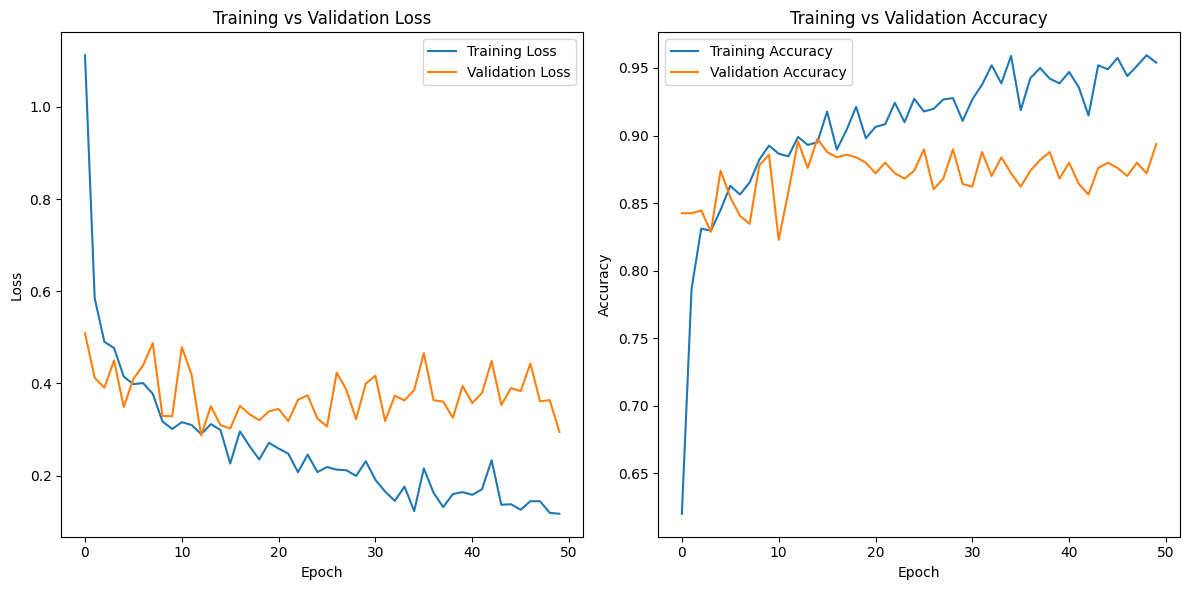

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_inception.history['loss'], label='Training Loss')
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training vs validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image as keras_image

def predict_waste_category(image_path, model):
    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((384, 512))  # Resize the image to match the input shape of the model
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict the category of waste
    prediction = model.predict(img_array)
    waste_categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
    predicted_category_index = np.argmax(prediction)
    predicted_category = waste_categories[predicted_category_index]

    # Get the probability associated with the predicted category
    probability = prediction[0][predicted_category_index]
    return predicted_category, probability
